# Parkinson Classification

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# read the file
environment_path = "C:\\MARTIN EDUARDO\\University Of Leeds\\Dissertation\\Classification_bradykinesia_KalmanFilter"
file_path = environment_path + "\mediaPipe_videos60fps.csv"

C:\Users\Martin Espinoza\anaconda3\envs\gpu3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parkinson Class:

In [2]:
class ParkinsonRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(ParkinsonRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Functions:

In [3]:
# read the file
def read_file(file_path):
    df = pd.read_csv(file_path)
    return df

# read videos
def read_videos(file_path):
    #test_videos_path = environment_path + "\\Data\\videos_data\\test_videos_60fps\\"
    student_names = [name for name in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, name))]
    all_videos = []
    for student_name in student_names:
        video_path = os.path.join(file_path, student_name)
        video_names = [os.path.splitext(name)[0] for name in os.listdir(video_path) if os.path.isfile(os.path.join(video_path, name))]
        all_videos.extend(video_names)
    return all_videos

# calculate the number of max frames (T)
def calculate_maxT(df, all_videos):
    maxT = 0
    for video in all_videos:
        maxT = max(maxT, df[df['image_name'].str.startswith(video)].shape[0])
    return maxT


# fill the tensor and labels
def fill_tensors_and_labels(df, mytensor, labels, all_videos, maxT):
    num_videos = len(all_videos)
    for i, video in enumerate(all_videos):
        video_data = df[df['image_name'].str.startswith(video)]
        T = video_data.shape[0]
        if T <= maxT:
            mytensor[i, 0, :T] = video_data['finger_x']
            mytensor[i, 1, :T] = video_data['finger_y']
            mytensor[i, 2, :T] = video_data['thumb_x']
            mytensor[i, 3, :T] = video_data['thumb_y']
        else:
            mytensor[i, 0, :maxT] = video_data['finger_x'][:maxT]
            mytensor[i, 1, :maxT] = video_data['finger_y'][:maxT]
            mytensor[i, 2, :maxT] = video_data['thumb_x'][:maxT]
            mytensor[i, 3, :maxT] = video_data['thumb_y'][:maxT]
        if video.startswith('P'):
            labels[i] = 1
    return mytensor, labels

# dataloaders for training
def create_train_and_validation_loaders(tensor_x, tensor_y, batch_size):
    # split into training and validation
    dataset = TensorDataset(tensor_x, tensor_y)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.2
    split = int(np.floor(validation_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    return train_loader, validation_loader

# train the Parkinson model
def training_model(model, train_loader, validation_loader, labels, num_epochs, learning_rate):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # to store the losses
    train_losses = []
    val_losses = []

    # training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, labels in validation_loader:
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        val_loss /= len(validation_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return model, train_losses, val_losses
                              
# make the predictions
def make_predictions(model, test_loader):
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions = torch.sigmoid(outputs).cpu().numpy()
            test_predictions.extend(predictions)
            test_targets.extend(labels.numpy())

    # metrics
    test_predictions = np.array(test_predictions).flatten()
    test_targets = np.array(test_targets)

    accuracy = accuracy_score(test_targets, np.round(test_predictions))
    recall = recall_score(test_targets, np.round(test_predictions))
    f1 = f1_score(test_targets, np.round(test_predictions))
    roc_auc = roc_auc_score(test_targets, test_predictions)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')
    print(f'Test AUROC: {roc_auc:.4f}')
    
# ploting the losses
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Train the Model

In [4]:
# models parameters
batch_size = 16
input_size = 4
hidden_size = 128  
num_layers = 3
output_size = 1
learning_rate = 0.0001 
dropout = 0.5 
num_epochs = 100

In [5]:
# read the files)
df = pd.read_csv(file_path) # train file

# read videos
all_videos = read_videos(environment_path + "\\Data\\videos_data\\videos_60fps\\")

# calculate the number of max frames (T)
maxT = calculate_maxT(df, all_videos)

# create the tensor and labels
num_videos = len(all_videos)
mytensor = np.zeros([num_videos, 4, maxT])
labels = np.zeros(num_videos)

# fill the tensor and labels
fill_tensors_and_labels(df, mytensor, labels, all_videos, maxT)

# tensors for x and y
tensor_x = torch.tensor(mytensor, dtype=torch.float32).permute(0, 2, 1) 
tensor_y = torch.tensor(labels, dtype=torch.float32)

# train and validation loaders
train_loader, validation_loader = create_train_and_validation_loaders(tensor_x, tensor_y, batch_size)

# train the model
model = ParkinsonRNN(input_size, hidden_size, num_layers, output_size, dropout)
model, train_losses, val_losses = training_model(model, train_loader, validation_loader, labels, num_epochs, learning_rate)

Epoch [1/100], Loss: 0.6934, Validation Loss: 0.6980
Epoch [2/100], Loss: 0.6923, Validation Loss: 0.7012
Epoch [3/100], Loss: 0.6916, Validation Loss: 0.7041
Epoch [4/100], Loss: 0.6901, Validation Loss: 0.7073
Epoch [5/100], Loss: 0.6886, Validation Loss: 0.7114
Epoch [6/100], Loss: 0.6940, Validation Loss: 0.7153
Epoch [7/100], Loss: 0.6872, Validation Loss: 0.7177
Epoch [8/100], Loss: 0.6823, Validation Loss: 0.7210
Epoch [9/100], Loss: 0.6946, Validation Loss: 0.7248
Epoch [10/100], Loss: 0.6893, Validation Loss: 0.7270
Epoch [11/100], Loss: 0.6841, Validation Loss: 0.7294
Epoch [12/100], Loss: 0.6895, Validation Loss: 0.7326
Epoch [13/100], Loss: 0.6779, Validation Loss: 0.7354
Epoch [14/100], Loss: 0.7017, Validation Loss: 0.7392
Epoch [15/100], Loss: 0.6883, Validation Loss: 0.7396
Epoch [16/100], Loss: 0.6819, Validation Loss: 0.7407
Epoch [17/100], Loss: 0.6819, Validation Loss: 0.7434
Epoch [18/100], Loss: 0.6811, Validation Loss: 0.7466
Epoch [19/100], Loss: 0.6879, Validat

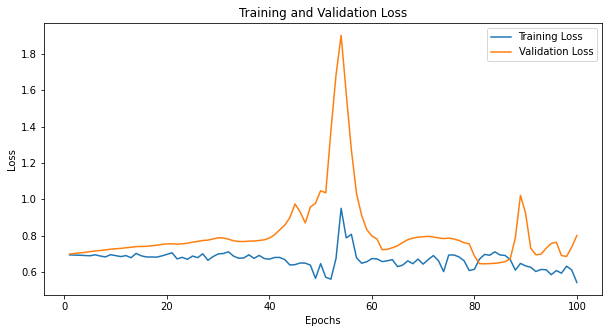

In [6]:
plot_losses(train_losses, val_losses, num_epochs)

### Test the model

In [7]:
# read the file (dataframe)
test_df = read_file(environment_path + "\\test_mediaPipe_videos60fps.csv")

# read the videos (list)
test_all_videos = read_videos(environment_path + "\\Data\\videos_data\\test_videos_60fps\\")
                              
# calculate the number of max frames (T)
test_maxT = calculate_maxT(test_df, test_all_videos)
                              
# create the tensor and labels
test_num_videos = len(test_all_videos)
test_mytensor = np.zeros([test_num_videos, 4, test_maxT])
test_labels = np.zeros(test_num_videos)
                      
# fill the tensor and labels
test_mytensor, test_labels = fill_tensors_and_labels(test_df, test_mytensor, test_labels, test_all_videos, test_maxT)

# tensors for x and y
test_tensor_x = torch.tensor(test_mytensor, dtype=torch.float32).permute(0, 2, 1) 
test_tensor_y = torch.tensor(test_labels, dtype=torch.float32)

# dataloader for test data
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                              
# predictions
make_predictions(model, test_loader)

Test Accuracy: 0.6667
Test Recall: 0.8000
Test F1-score: 0.7273
Test AUROC: 0.6500
